In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import random
from pathlib import Path
from typing import List

import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from PIL import Image
from torchvision.models import get_model
from torchvision.transforms.v2 import (
    Compose,
    Resize,
    ToDtype,
    ToImage,
    Normalize,
    ColorJitter,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomGrayscale,
    GaussianBlur,
)
from torch.nn import Module, Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy, MeanMetric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = Path('/content/drive/MyDrive/dataset car/car_data/car_data/test')
MEAN = [0.47028565, 0.4600675 , 0.4550754]
STD = [0.26398006, 0.26271883, 0.26737422]
IMAGE_SIZE = 256

In [ ]:
class CarDataset(Dataset):
    def __init__(self, images: List[Image.Image], labels: List[int], augment: bool = False) -> None:
        self.augment = augment
        self.augment_transform = Compose(
            [
                ToImage(),
                RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.3, 1.0), antialias=True),
                ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                RandomHorizontalFlip(),
                RandomGrayscale(),
                GaussianBlur(kernel_size=3),
                ToDtype(torch.float32, scale=True),
                Normalize(mean=MEAN, std=STD),
            ]
        )
        self.transform = Compose(
            [
                ToImage(),
                Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=False),
                ToDtype(torch.float32, scale=True),
                Normalize(mean=MEAN, std=STD),
            ]
        )
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        if self.augment:
            image = self.augment_transform(image)
        else:
            image = self.transform(image)
        return image, torch.tensor(self.labels[index], dtype=torch.int64)


class CarTrainer:
    def __init__(
        self,
        model: Module,
        criterion: CrossEntropyLoss,
        optimizer: Adam,
        num_classes: int,
        device: str,
    ) -> None:
        self.device = device
        self.model = model.to(device)
        self.criterion = criterion.to(device)
        self.optimizer = optimizer

        self.accuracy = Accuracy(
            task="multiclass", num_classes=num_classes, top_k=1
        ).to(device)
        self.train_loss = MeanMetric().to(device)
        self.train_accuracy = MeanMetric().to(device)
        self.val_loss = MeanMetric().to(device)
        self.val_accuracy = MeanMetric().to(device)

    def fit(
        self,
        train_dataset: CarDataset,
        val_dataset: CarDataset,
        batch_size: int,
        epochs: int,
        verbose: bool = False,
    ) -> None:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False
        )

        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}/{epochs}:")

            self._train_one_epoch(train_loader, verbose=verbose)
            self._validate_one_epoch(val_loader, verbose=verbose)

            print(
                f"loss {self.train_loss.compute():.4f} - "
                f"accuracy {self.train_accuracy.compute():.4f} - "
                f"val loss {self.val_loss.compute():.4f} - "
                f"val accuracy {self.val_accuracy.compute():.4f}"
            )

            for metric in (self.train_loss, self.train_accuracy, self.val_loss, self.val_accuracy):
                metric.reset()

    def _train_one_epoch(self, loader: DataLoader, verbose: bool) -> None:
        self.model.train()

        with tqdm(total=len(loader), desc="Training", disable=not verbose) as progress_bar:
            for batch in loader:
                images = batch[0].to(device)
                labels = batch[1].to(device)

                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                loss.backward()
                self.optimizer.step()

                self.train_loss.update(loss.item())
                self.train_accuracy.update(self.accuracy(logits, labels))
                mean_loss = self.train_loss.compute()
                mean_accuracy = self.train_accuracy.compute()
                progress_bar.set_description(f"loss {mean_loss:.4f} - accuracy {mean_accuracy:.4f}")
                progress_bar.update()

    def _validate_one_epoch(self, loader: DataLoader, verbose: bool) -> None:
        self.model.eval()

        with torch.no_grad(), tqdm(total=len(loader), disable=not verbose) as progress_bar:
            for batch in loader:
                images = batch[0].to(device)
                labels = batch[1].to(device)

                logits = self.model(images)
                loss = self.criterion(logits, labels)

                self.val_loss.update(loss.item())
                self.val_accuracy.update(self.accuracy(logits, labels))
                mean_loss = self.val_loss.compute()
                mean_accuracy = self.val_accuracy.compute()
                progress_bar.set_description(f"loss {mean_loss:.4f} - accuracy {mean_accuracy:.4f}")
                progress_bar.update()

In [ ]:
image_paths = list(DATASET_PATH.rglob("*.jpg"))
labels = list({x.parent.name for x in image_paths})
label_map = {x: i for i, x in enumerate(labels)}

train_image_paths, val_image_paths = train_test_split(
    image_paths, test_size=0.2, shuffle=True
)

train_images = [
    Image.open(x).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    for x in tqdm(train_image_paths)
]
val_images = [
    Image.open(x).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    for x in tqdm(val_image_paths)
]
train_labels = [label_map[x.parent.name] for x in train_image_paths]
val_labels = [label_map[x.parent.name] for x in val_image_paths]

  0%|          | 0/6432 [00:00<?, ?it/s]

  0%|          | 0/1609 [00:00<?, ?it/s]

In [ ]:
train_dataset = CarDataset(train_images, train_labels, augment=True)
val_dataset = CarDataset(val_images, val_labels)

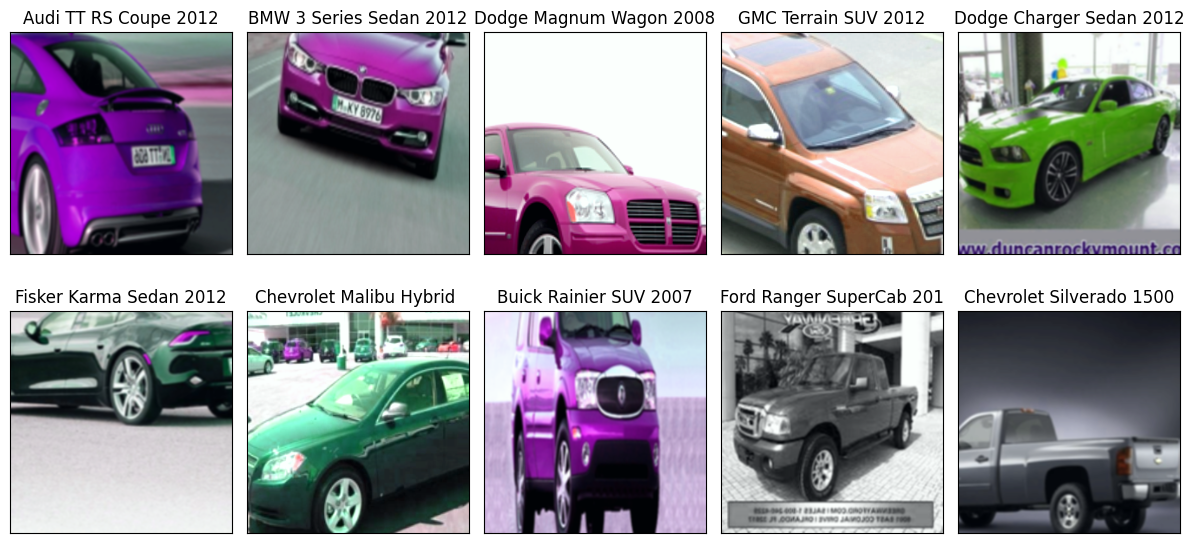

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()

for ax in axes:
    index = random.randint(0, len(train_dataset) - 1)
    image, target = train_dataset[index]
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image)
    ax.set_title(labels[target.item()][:24])
    ax.set_xticks([])
    ax.set_yticks([])

figure.tight_layout()


In [ ]:
import torch

# Verifikasi apakah GPU tersedia
print("CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())
print("Current CUDA device: ", torch.cuda.current_device())
print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available:  True
CUDA device count:  1
Current CUDA device:  0
Device name:  Tesla T4


In [ ]:
device = "cuda"
model = get_model("efficientnet_v2_s", weights="DEFAULT")
model.classifier[1] = Linear(in_features=1280, out_features=len(labels))
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())
trainer = CarTrainer(model=model, criterion=criterion, optimizer=optimizer, num_classes=len(labels), device=device)
trainer.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=32,
    epochs=30,
    verbose=True,
)
torch.save(model.state_dict(), "model.pt")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 142MB/s]


Epoch 1/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/51 [00:00<?, ?it/s]

loss 4.6443 - accuracy 0.0504 - val loss 3.7980 - val accuracy 0.1180
Epoch 2/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 3.0941 - accuracy 0.2243 - val loss 2.5819 - val accuracy 0.2899
Epoch 3/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 2.0146 - accuracy 0.4485 - val loss 1.8468 - val accuracy 0.4993
Epoch 4/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 1.4484 - accuracy 0.5959 - val loss 1.3954 - val accuracy 0.5859
Epoch 5/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 1.1302 - accuracy 0.6766 - val loss 1.1210 - val accuracy 0.6739
Epoch 6/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.9017 - accuracy 0.7390 - val loss 0.9282 - val accuracy 0.7177
Epoch 7/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.7338 - accuracy 0.7819 - val loss 0.9635 - val accuracy 0.7121
Epoch 8/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.6539 - accuracy 0.8067 - val loss 0.9602 - val accuracy 0.7175
Epoch 9/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.5589 - accuracy 0.8330 - val loss 0.9223 - val accuracy 0.7254
Epoch 10/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.4974 - accuracy 0.8515 - val loss 0.8466 - val accuracy 0.7536
Epoch 11/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.4634 - accuracy 0.8626 - val loss 0.7883 - val accuracy 0.7781
Epoch 12/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.4289 - accuracy 0.8730 - val loss 0.8024 - val accuracy 0.7692
Epoch 13/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.3839 - accuracy 0.8781 - val loss 0.7631 - val accuracy 0.7947
Epoch 14/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.3846 - accuracy 0.8837 - val loss 0.7640 - val accuracy 0.7784
Epoch 15/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.3658 - accuracy 0.8882 - val loss 0.8285 - val accuracy 0.7655
Epoch 16/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.3407 - accuracy 0.8969 - val loss 0.7110 - val accuracy 0.8008
Epoch 17/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.3110 - accuracy 0.9044 - val loss 0.8043 - val accuracy 0.7802
Epoch 18/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.3293 - accuracy 0.8983 - val loss 0.8323 - val accuracy 0.7713
Epoch 19/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2753 - accuracy 0.9142 - val loss 0.8279 - val accuracy 0.7811
Epoch 20/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2649 - accuracy 0.9238 - val loss 0.6737 - val accuracy 0.8151
Epoch 21/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2831 - accuracy 0.9143 - val loss 0.7110 - val accuracy 0.8106
Epoch 22/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2521 - accuracy 0.9238 - val loss 0.8069 - val accuracy 0.7796
Epoch 23/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2470 - accuracy 0.9257 - val loss 0.8029 - val accuracy 0.7888
Epoch 24/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2305 - accuracy 0.9283 - val loss 0.7856 - val accuracy 0.7983
Epoch 25/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2457 - accuracy 0.9263 - val loss 0.7136 - val accuracy 0.8054
Epoch 26/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2404 - accuracy 0.9251 - val loss 0.7689 - val accuracy 0.7915
Epoch 27/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2565 - accuracy 0.9260 - val loss 0.7620 - val accuracy 0.8026
Epoch 28/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2183 - accuracy 0.9361 - val loss 0.6739 - val accuracy 0.8152
Epoch 29/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2251 - accuracy 0.9303 - val loss 0.8208 - val accuracy 0.7840
Epoch 30/30:


Training:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

loss 0.2030 - accuracy 0.9383 - val loss 0.6930 - val accuracy 0.8152


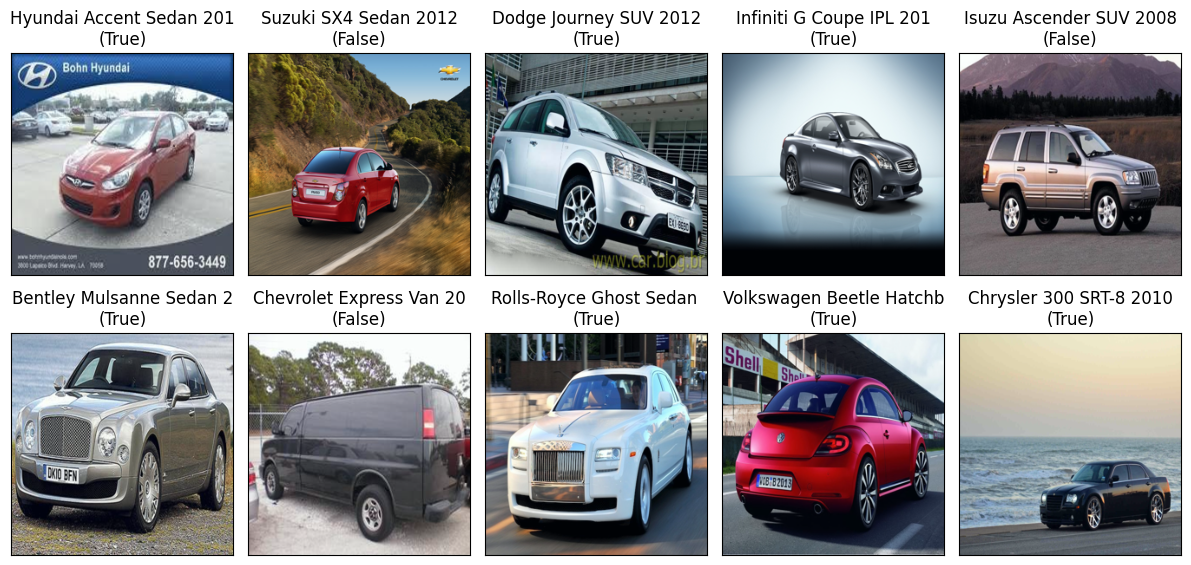

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()
model.eval()

for ax in axes:
    index = random.randint(0, len(val_dataset) - 1)

    image, label = val_dataset[index]
    predict = model(image.to("cuda").unsqueeze(0))[0].argmax().item()
    correct = predict == label.item()

    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())

    ax.imshow(image)
    ax.set_title(f"{labels[predict][:24]}\n({correct})")
    ax.set_xticks([])
    ax.set_yticks([])

figure.tight_layout()
figure.show()